# Sider with Mol2Vec

# Implementação da Baseline

- Nesta implementação vamos usar um modelo Mol2vec pre-treinado para criar embeddings dos compostos (Algo que esteja implementado no DeepChem). 

- Depois vamos usar os embeddings (carregados como NumpyDataset) como input para um modelo MultitaskClassifier.


In [1]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import Word2Vec
from gensim.models import word2vec
from rdkit import Chem
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from deepchem.data.datasets import NumpyDataset
import os
import deepchem as dc

from deepchem.data.datasets import NumpyDataset # import NumpyDataset


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
"""
SIDER dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_for_mol2vec(featurizer='ECFP', split='index', reload=True, K=4):
  """Load MUV datasets. Does not do train/test split"""
  # Load Sider dataset
  logger.info("About to load Sider dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sider/" + featurizer + "/" + str(split))

  #dataset_file = os.path.join(data_dir, "muv.csv.gz")
  dataset_file = os.path.join("./", "sider.csv.gz")
  #if not os.path.exists(dataset_file):
  #  deepchem.utils.download_url(
  #      'http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/muv.csv.gz'
  #  )

  SIDER_tasks = sorted([ 'Hepatobiliary disorders',
       'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
       'Investigations', 'Musculoskeletal and connective tissue disorders',
       'Gastrointestinal disorders', 'Social circumstances',
       'Immune system disorders', 'Reproductive system and breast disorders',
       'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
       'General disorders and administration site conditions',
       'Endocrine disorders', 'Surgical and medical procedures',
       'Vascular disorders', 'Blood and lymphatic system disorders',
       'Skin and subcutaneous tissue disorders',
       'Congenital, familial and genetic disorders',
       'Infections and infestations',
       'Respiratory, thoracic and mediastinal disorders',
       'Psychiatric disorders', 'Renal and urinary disorders',
       'Pregnancy, puerperium and perinatal conditions',
       'Ear and labyrinth disorders', 'Cardiac disorders',
       'Nervous system disorders',
       'Injury, poisoning and procedural complications'
  ])

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return SIDER_tasks, all_dataset, transformers

  # Featurize MUV dataset
  logger.info("About to featurize MUV dataset.")

  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return SIDER_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    all_dataset = (train, valid, test)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
  return SIDER_tasks, all_dataset, transformers


In [3]:
tasks, datasets, transformers = load_sider_for_mol2vec()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
test_smiles = test_dataset.ids

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [4]:
len(train_dataset)

1141

In [5]:
train_dataset.ids

array(['C(CNCCNCCNCCN)N',
       'CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=O)O)C(C)(C)C',
       'CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4=CCCC[C@H]34',
       ..., 'CC12CC(C3(C(C1CC(C2(C(=O)CO)O)O)CCC4=CC(=O)C=CC43C)F)O',
       'CC1=CC(=CC(=C1OC2=NC(=NC(=C2Br)N)NC3=CC=C(C=C3)C#N)C)C#N',
       'CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4Cl'], dtype=object)

In [6]:
# Get SMILES from file
def getSMILES(filepath):
    df = pd.read_csv(filepath)    
    smiles_df = df[['smiles']].dropna()
    return smiles_df

In [7]:
# Generate molecules from SMILES strings
def generateEmbeddings(smiles_df, trained_model):
    smiles = list(smiles_df['smiles'])
    smiles = [x.split(';')[0] for x in smiles]
    # SMILES to Mol
    molecules = [Chem.MolFromSmiles(x) for x in smiles]
    # Load previously trained mol2vec model
    model = Word2Vec.load(trained_model)
    # Convert molecules to sentences and then to embeddings
    sentences = [mol2alt_sentence(x, 1) for x in molecules]
    vectors = [DfVec(x) for x in sentences2vec(sentences, model, unseen='UNK')]
    vec_df = pd.DataFrame(data=np.array([x.vec for x in vectors]))
    vec_df.columns = ['mol2vec_' + str(x+1) for x in vec_df.columns.values]
    vec_df.index = smiles_df.index.values
    return pd.concat([smiles_df, vec_df], axis=1)

In [8]:
train_smiles_from_sider=pd.DataFrame(train_smiles,  columns=['smiles'])
valid_smiles_from_sider=pd.DataFrame(valid_smiles,  columns=['smiles'])
test_smiles_from_sider=pd.DataFrame(test_smiles,  columns=['smiles'])

In [9]:
len(train_smiles_from_sider)

1141

In [10]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/mamonteiro/source-code/Project-LEI/sider
Directory name is : sider


In [11]:
#Estas 3 linhas deveriam ser feitas de outra maneira
#Deveriamos fazer o mesmo com o dataset completo mas neste momento vai ficar assim pelo receio que tenho de nao ter o dataset dividido como suposto

train_embeddings_generated_from_mol2vec = generateEmbeddings(train_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
valid_embeddings_generated_from_mol2vec = generateEmbeddings(valid_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
test_embeddings_generated_from_mol2vec = generateEmbeddings(test_smiles_from_sider, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

In [12]:
train_embeddings_generated_from_mol2vec.head()

,smiles,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,C(CNCCNCCNCCN)N,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,...,1.845091,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742257,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,-0.227203,-2.800524,-1.099674,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [13]:
len(train_embeddings_generated_from_mol2vec),len(valid_embeddings_generated_from_mol2vec),len(test_embeddings_generated_from_mol2vec) 

(1141, 143, 143)

In [14]:
train_embeddings_generated_from_mol2vec.iloc[0][0]

'C(CNCCNCCNCCN)N'

In [15]:
train_embeddings=train_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
valid_embeddings=valid_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
test_embeddings=test_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)

In [16]:
train_embeddings.head()

,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,mol2vec_10,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,-0.990727,-1.723967,1.596080,0.336589,5.995870,1.602312,-7.893780,-0.770941,2.798226,-4.712134,...,1.845091,4.080578,5.290233,2.681949,-6.017433,0.732134,-0.161610,-7.355957,-6.514126,-4.416229
1,0.596306,0.060384,-4.686247,4.381831,2.139633,-0.343262,-13.849467,0.780369,9.671047,4.445226,...,-0.760953,9.614191,13.119958,-0.408570,-7.577562,-4.803534,-4.880173,-7.033062,-15.572207,-4.429869
2,1.854099,-4.819261,0.775984,3.286393,1.519570,-6.281527,-10.383826,5.000489,-0.742257,0.579260,...,0.873612,15.422496,-1.348580,-1.571692,-17.224537,-6.963869,-12.192692,-3.912728,-8.017673,1.265650
3,2.140168,-5.169839,-0.039611,3.000724,0.787211,-6.880911,-10.384640,5.767844,-0.478307,0.191780,...,0.627151,15.921182,-1.159732,-1.260444,-17.655016,-7.629984,-13.157971,-3.574889,-8.912206,1.509292
4,-0.227203,-2.800524,-1.099674,4.259158,-1.261016,-2.570959,-8.051775,1.025365,6.135835,2.401863,...,-0.972749,9.117423,7.184863,-0.012285,-7.312431,-1.483516,-4.117091,-2.378627,-9.008883,-0.717169


In [17]:
train_embeddings.isnull().any().any()

False

In [18]:
len(train_embeddings.columns)

300

In [19]:
len(train_embeddings)

1141

In [20]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 50
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [21]:
#dataset_with_weights

In [22]:
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w,
                                                train_dataset.ids)

In [23]:
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w,
                                                valid_dataset.ids)

In [24]:
test_embeddings_dataset = dc.data.NumpyDataset(test_embeddings,
                                                test_dataset.y,
                                                test_dataset.w,
                                                test_dataset.ids)

In [25]:
nb_epochs=[50,100, 150, 200,250,300,400,500,1000,2000]
losses = []
loss =0

In [26]:
model = dc.models.MultitaskClassifier(n_tasks=27,
                                      n_features=300,
                                      layer_sizes=[512])

for epoch in nb_epochs :
    loss = model.fit(train_embeddings_dataset, epoch=epoch)
    print("Epoch %d loss: %f" % (epoch, loss))
    losses.append(loss)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Epoch 50 loss: 1702.814650
Epoch 100 loss: 1453.071419
Epoch 150 loss: 1413.613593
Epoch 200 loss: 1390.167327
Epoch 250 loss: 1369.464629
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch 300 loss: 1337.737402
Epoch 400 loss: 1331.885448
Epoch 500 loss: 1313.393778
Epoch 1000 loss: 1301.574305
Epoch 2000 loss: 1288.130271


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

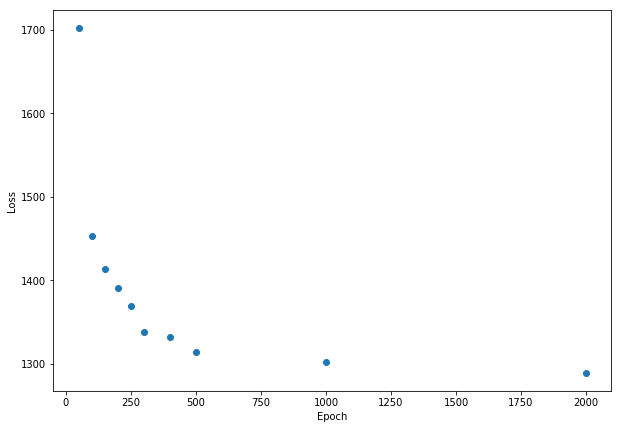

In [27]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = nb_epochs
y = losses
plot.scatter(x, y)
plot

In [28]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
train_score = model.evaluate(train_embeddings_dataset, [metric], transformers)
print('\n')
print('Training set ROC AUC:', train_score)

computed_metrics: [0.7987732733513626, 0.80583645443196, 0.7674468833191019, 0.7545170519287742, 0.8146831510620565, 0.7733852309355411, 0.8655993718373758, 0.7851815304743618, 0.7977572396796057, 0.7222271723550149, 0.7428387602103614, 0.7301491918773312, 0.8247282872392043, 0.7645276220091816, 0.7602316364085104, 0.82854537610793, 0.8874651116427432, 0.8574278359992646, 0.9620977577633925, 0.7971611407302321, 0.7577958693403624, 0.7874744715927265, 0.7721629270264807, 0.818316036570299, 0.800683306979896, 0.784160091851154, 0.774087710241013]


Training set ROC AUC: {'mean-roc_auc_score': 0.7976022404801939}


In [29]:
valid_score = model.evaluate(valid_embeddings_dataset, [metric], transformers)
print('\n')
print('Validation set ROC AUC:', valid_score)

computed_metrics: [0.5995069475571493, 0.6241595696996862, 0.6104605776736924, 0.6297429620563035, 0.6600140056022409, 0.5937624950019992, 0.4042081949058693, 0.6246556473829201, 0.6803797468354431, 0.5498670212765958, 0.6674418604651162, 0.5183290707587382, 0.6758076634109691, 0.5683639792550683, 0.4882205513784461, 0.6264076576576576, 0.6138676844783715, 0.7779898218829516, 0.8450704225352113, 0.6083720930232558, 0.555362570560139, 0.6570247933884297, 0.5447922288181327, 0.6491141732283465, 0.5976271186440678, 0.6239837398373984, 0.5569321533923304]


Validation set ROC AUC: {'mean-roc_auc_score': 0.6130172129891308}


In [30]:
test_score = model.evaluate(test_embeddings_dataset, [metric], transformers)
print('\n')
print('Validation set ROC AUC:', test_score)

computed_metrics: [0.5659806295399517, 0.589832285115304, 0.6475256769374417, 0.6239911218724778, 0.7638983050847458, 0.6221568627450981, 0.5974409448818898, 0.5364583333333333, 0.7007515822784811, 0.6877551020408164, 0.659906914893617, 0.6019322622666088, 0.6990320629159106, 0.6202046035805627, 0.667233560090703, 0.6844181459566075, 0.6559895833333333, 0.5527777777777778, 0.5585106382978724, 0.7029960920538427, 0.6767645858833129, 0.6814358372456963, 0.6611268269684112, 0.6470588235294117, 0.6071428571428571, 0.5193744164332399, 0.537128712871287]


Validation set ROC AUC: {'mean-roc_auc_score': 0.6321786868544663}


[(0, 0.6637876211971896)]

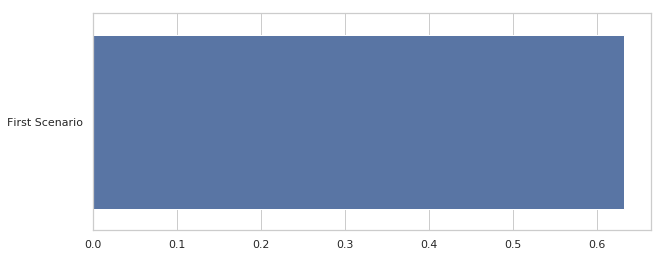

In [31]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score']],
                 y=['First Scenario'])
ax.set(xlim=(0, None))


# Valores com hyperparameters

In [32]:
sider_tasks = sorted([ 'Hepatobiliary disorders',
   'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
   'Investigations', 'Musculoskeletal and connective tissue disorders',
   'Gastrointestinal disorders', 'Social circumstances',
   'Immune system disorders', 'Reproductive system and breast disorders',
   'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
   'General disorders and administration site conditions',
   'Endocrine disorders', 'Surgical and medical procedures',
   'Vascular disorders', 'Blood and lymphatic system disorders',
   'Skin and subcutaneous tissue disorders',
   'Congenital, familial and genetic disorders',
   'Infections and infestations',
   'Respiratory, thoracic and mediastinal disorders',
   'Psychiatric disorders', 'Renal and urinary disorders',
   'Pregnancy, puerperium and perinatal conditions',
   'Ear and labyrinth disorders', 'Cardiac disorders',
   'Nervous system disorders',
   'Injury, poisoning and procedural complications'
])


In [33]:
params_dict = {"activation": ["relu","sigmoid","tanh"],
               "optimizer": ['RMSprop','adam'],
               "momentum": [.9],
               "dropouts": [.5,0.2],
               "nb_layers": [512],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(sider_tasks), n_features, **model_params)
    return model

In [34]:
train_dataset.get_data_shape()[0]

1024

In [35]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.6781712236665173, 0.6770506499327655, 0.6389539422326307, 0.6148510811913505, 0.6242997198879552, 0.5605757696921232, 0.7436323366555925, 0.6363636363636365, 0.7339794303797469, 0.5591755319148937, 0.6451162790697674, 0.5792838874680307, 0.7235161532682195, 0.5832154644035832, 0.575187969924812, 0.665259009009009, 0.75, 0.7360050890585241, 0.823943661971831, 0.6134883720930233, 0.6508901432913591, 0.6688311688311688, 0.628440366972477, 0.6796259842519685, 0.5467796610169491, 0.5296747967479676, 0.6339233038348083]
Model 1/12, Metric mean-roc_auc_score, Validation set 0: 0.648157
	best_validation_score so far: 0.648157
Fitting model 2/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.6786194531600179, 0.6620349619

computed_metrics: [0.6844464365755267, 0.6754818467055131, 0.6510538641686183, 0.627906976744186, 0.6190476190476191, 0.5693722510995601, 0.7081949058693244, 0.6301652892561984, 0.7242879746835444, 0.5649379432624113, 0.6453488372093024, 0.5812020460358056, 0.7235161532682194, 0.5839226779820839, 0.5859649122807018, 0.6793355855855856, 0.7258269720101781, 0.7442748091603053, 0.8943661971830986, 0.6106976744186046, 0.662613981762918, 0.6672569854388035, 0.6386940097139773, 0.6830708661417323, 0.5457627118644068, 0.55, 0.5790560471976401]
Model 11/12, Metric mean-roc_auc_score, Validation set 10: 0.650215
	best_validation_score so far: 0.652177
Fitting model 12/12
hyperparameters: {'activation': 'tanh', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.6687584043030032, 0.6521739130434783, 0.6221701795472288, 0.6301509587923296, 0.6214985994397759, 0.5663734506197521, 0.7674418604651163, 0.6763085399449036, 0.7217167721518987, 0

In [36]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1024, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [37]:
best_hyperparams

('tanh', 'adam', 0.9, 0.2, 512, 0.0)

In [38]:
obj=best_dnn.fit(train_dataset,**params_dict)

In [39]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [40]:
train_scores = best_dnn.evaluate(train_dataset, [metric], transformers)
print(train_scores)

computed_metrics: [0.960877366340753, 0.963866857604465, 0.991559093877141, 0.9632476579389864, 0.9840207444076815, 0.9594874068117251, 0.9765117586614708, 0.969161154967641, 0.9659827479975355, 0.9447642660674853, 0.9465256797583081, 0.9473062577704103, 0.959383794274624, 0.9469997863043174, 0.9443157978789044, 0.9885402776688368, 0.9722089314194577, 0.9966537966537967, 0.9992025518341308, 0.9616254414265992, 0.9596743518734778, 0.9700548706970793, 0.9409015564988881, 0.9758710155670867, 0.9899788487997208, 0.9921808761186999, 0.9534141238485994]
{'mean-roc_auc_score': 0.9675672967802896}


In [41]:
valid_scores = best_dnn.evaluate(valid_dataset, [metric], transformers)
print(valid_scores)


computed_metrics: [0.6743612729717616, 0.6696548632900046, 0.6112412177985949, 0.6219910240718074, 0.6292016806722689, 0.5793682526989203, 0.7851605758582503, 0.7258953168044078, 0.703125, 0.5859929078014184, 0.6323255813953488, 0.5705456095481671, 0.6945905334335085, 0.6037246581801037, 0.5942355889724311, 0.6692004504504505, 0.7270992366412214, 0.7633587786259541, 0.9084507042253521, 0.6376744186046511, 0.6478506296135476, 0.6922471467926015, 0.6497571505666487, 0.6697834645669292, 0.5335593220338983, 0.556910569105691, 0.5961651917404129]
{'mean-roc_auc_score': 0.6567952276468279}


In [42]:
test_scores_v1 = best_dnn.evaluate(test_dataset, [metric], transformers)
print(test_scores_v1)

computed_metrics: [0.6721146085552865, 0.630607966457023, 0.469187675070028, 0.602905569007264, 0.7101694915254237, 0.6184313725490196, 0.812992125984252, 0.6541666666666666, 0.7353639240506329, 0.6811791383219954, 0.6972517730496455, 0.603126356925749, 0.7534785238959467, 0.6994884910485935, 0.6557823129251701, 0.6969921104536488, 0.7734375, 0.475, 0.10283687943262412, 0.6406860616587061, 0.7186862505099959, 0.6643192488262911, 0.6765676567656767, 0.711484593837535, 0.5522875816993464, 0.5975723622782447, 0.670909948137671]
{'mean-roc_auc_score': 0.6398898588752755}


# Nossos resultados Finais

[(0, 0.6718843518190393)]

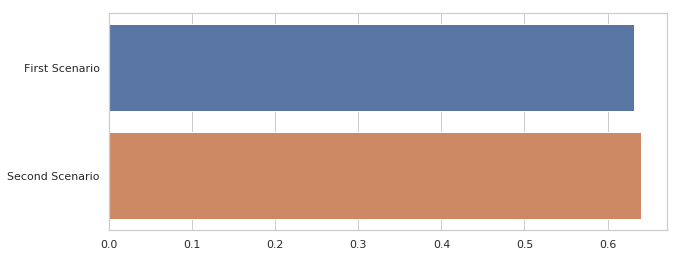

In [43]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score'],test_scores_v1['mean-roc_auc_score']],
                 y=['First Scenario','Second Scenario'])
ax.set(xlim=(0, None))

In [46]:
print(test_score['mean-roc_auc_score'])
print(test_scores_v1['mean-roc_auc_score'])


0.6321786868544663
0.6398898588752755
